In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def display_reconstructed(original_img, decoded_img, n=10):
    plt.figure(figsize=(10, 4))

    for i in range(n):
        # display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_img is not None:
            # display decoded images
            ax = plt.subplot(2, n, i + n + 1)
            plt.imshow(decoded_img[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.savefig(f'drive/My Drive/Notebooks/{int(time.time())}.png')
    plt.show()

(60000, 28, 28, 1)
(10000, 28, 28, 1)


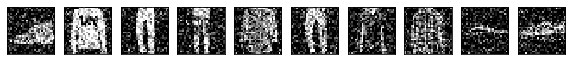

In [12]:
(train_x, _), (test_x, _) = fashion_mnist.load_data()

train_x = train_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255

train_x = train_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

print(train_x.shape)
print(test_x.shape)

noise_factor = 0.3
train_x_noisy = train_x + noise_factor * np.random.normal(loc=0.0,
                                                          scale=1,
                                                          size=train_x.shape)

test_x_noisy = test_x + noise_factor * np.random.normal(loc=0.0,
                                                        scale=1,
                                                        size=test_x.shape)

train_x_noisy = np.clip(train_x_noisy, 0., 1.)
test_x_noisy = np.clip(test_x_noisy, 0., 1.)

display_reconstructed(test_x_noisy, None)

In [16]:
def encoder(input_img):
    # encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    
    return conv4


def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    
    return decoded
  

input_img = Input(shape=(28, 28, 1))
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer='rmsprop')

plot_model(autoencoder, to_file='drive/My Drive/Notebooks/fmnist_deep.png', show_shapes=True)

W0713 15:20:25.976209 139981198702464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



In [17]:
fpath = 'drive/My Drive/Notebooks/fmnist_deep.h5'

mc = ModelCheckpoint(fpath, verbose=1, save_best_only=True,
                     monitor='val_loss', save_weights_only=False)

es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

log = CSVLogger('drive/My Drive/Notebooks/fmnist_deep_log.csv', append=True)

print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [18]:
autoencoder.fit(train_x_noisy, train_x, epochs=200,
                validation_data=(test_x_noisy, test_x),
                callbacks=[mc, log, es])

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 142s 2ms/step - loss: 0.0180 - val_loss: 0.0139

Epoch 00001: val_loss improved from inf to 0.01394, saving model to drive/My Drive/Notebooks/fmnist_deep.h5
Epoch 2/200
60000/60000 [==============================] - 136s 2ms/step - loss: 0.0110 - val_loss: 0.0099

Epoch 00002: val_loss improved from 0.01394 to 0.00991, saving model to drive/My Drive/Notebooks/fmnist_deep.h5
Epoch 3/200
60000/60000 [==============================] - 134s 2ms/step - loss: 0.0098 - val_loss: 0.0113

Epoch 00003: val_loss did not improve from 0.00991
Epoch 4/200
60000/60000 [==============================] - 133s 2ms/step - loss: 0.0091 - val_loss: 0.0097

Epoch 00004: val_loss improved from 0.00991 to 0.00968, saving model to drive/My Drive/Notebooks/fmnist_deep.h5
Epoch 5/200
60000/60000 [==============================] - 134s 2ms/step - loss: 0.0085 - val_loss: 0.0087

Epoch 00005: val_loss impro

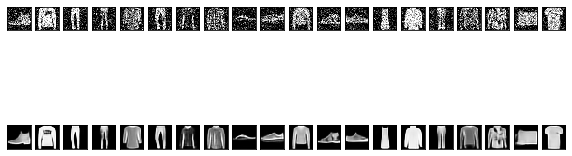

In [20]:
autoencoder.load_weights('drive/My Drive/Notebooks/fmnist_deep.h5')
pred_img = autoencoder.predict(test_x_noisy)
display_reconstructed(test_x_noisy, pred_img, 20)